In [25]:
from fenics import * 
import matplotlib.pyplot as plt
import numpy as np
import time

#suppress some output
import logging
logging.getLogger('FFC').setLevel(logging.WARNING)

In [26]:
## Simulation and mesh parameters

# mesh size
Lx = 1.0         
Ly = 20.0

# set grid size
mx = 20/4
my = int(mx*Ly)

# xi slice
J = 31
SHIFT = np.linspace(0.0,1.0,J) - 1.0/3.0
#SHIFT = np.linspace(1.0/3.0-1.0/16.0,1.0/3.0,J) - 1.0/3.0

# number of eigenvalues
evals = 2*1*int(Ly)+2
E = np.zeros((J,evals))

In [27]:
## Mesh

# set up honeycomb lattice
q = 4*np.pi/(sqrt(3))
k1 = q*np.array([1,sqrt(3)])/2.0
k2 = q*np.array([1,-sqrt(3)])/2.0
k3 = -(k1+k2)
K = (k1-k2)/3

v1_h = np.array([sqrt(3),1])/2.0
v2_h = np.array([sqrt(3),-1])/2.0

# different edges
# a1 = 1; b1 = 1; a2 = 0; b2 = 1;     # armchair
a1, b1, a2, b2 = 1, 0, 0, 1       # zigzag
# a1 = 3; b1 = 2; a2 = 1; b2 = 1;     # general
# a1 = 2; b1 = 1; a2 = 1; b2 = 1;     # general

v1 = a1*v1_h + b1*v2_h
v2 = a2*v1_h + b2*v2_h

ktilde = -b1*k1+a1*k2         # general

# create mesh      
def honeycomb_cylinder(x, y):
    return [v1[0]*x + v2[0]*y, v1[1]*x + v2[1]*y]

mesh = RectangleMesh(Point(-Lx/2,-Ly/2),Point(Lx/2,Ly/2),mx,my)#, 'left') # “left”, “right”, “left/right”, “crossed”
x = mesh.coordinates()[:,0]
y = mesh.coordinates()[:,1]

x_hat, y_hat = honeycomb_cylinder(x, y)
xy_hat_coor = np.array([x_hat, y_hat]).transpose()
mesh.coordinates()[:] = xy_hat_coor
#plot(mesh), interactive()

In [28]:
## Boundary Conditions

# sub domain for Dirichlet boundary condition
class DirichletBoundary(SubDomain):
    def inside(self, x, on_boundary):
        detv = v1[0]*v2[1] - v2[0]*v1[1]
        y_r = (-v1[1]*x[0] + v1[0]*x[1])/detv
        return bool( ( near(y_r, -Ly/2.0) or near(y_r, Ly/2.0) ) and on_boundary)
    
# sub domain for Periodic boundary condition
class PeriodicBoundary(SubDomain):

    # left boundary is "target domain" G
    def inside(self, x, on_boundary):
        detv = v1[0]*v2[1] - v2[0]*v1[1]
        x_r = (v2[1]*x[0] - v2[0]*x[1])/detv
        return bool( ( near(x_r, -Lx/2.0) and near(x_r, -Lx/2.0) ) and on_boundary)

    # map right boundary (H) to left boundary (G)
    def map(self, x, y):
        detv = v1[0]*v2[1] - v2[0]*v1[1]
        x_r = (v2[1]*x[0] - v2[0]*x[1])/detv
        y_r = (-v1[1]*x[0] + v1[0]*x[1])/detv 
        
        x_h = x_r - (Lx - 0)
        y_h = y_r
        
        y[0] = v1[0]*x_h + v2[0]*y_h
        y[1] = v1[1]*x_h + v2[1]*y_h
        
## perfectly periodic problem

# sub domain for Periodic boundary condition
class PerfectlyPeriodicBoundary(SubDomain):

    # left boundary is "target domain" G
    def inside(self, x, on_boundary):
        detv = v1[0]*v2[1] - v2[0]*v1[1]
        x_r = (v2[1]*x[0] - v2[0]*x[1])/detv
        y_r = (-v1[1]*x[0] + v1[0]*x[1])/detv 
        
        return bool( (near(x_r, -Lx/2.0) or near(y_r, -Ly/2.0)) and 
                    (not ((near(x_r, -Lx/2.0) and near(y_r, +Ly/2.0)) or 
                            (near(x_r, +Lx/2.0) and near(y_r, -Ly/2.0))) ) and on_boundary)
        
    # map right boundary (H) to left boundary (G)
    def map(self, x, y):
        detv = v1[0]*v2[1] - v2[0]*v1[1]
        x_r = (v2[1]*x[0] - v2[0]*x[1])/detv
        y_r = (-v1[1]*x[0] + v1[0]*x[1])/detv 
        
        if near(x_r, +Lx/2.0) and near(y_r, +Ly/2.0):
            x_h = x_r  - Lx - 0.0
            y_h = y_r - Ly - 0.0
        elif near(x_r, +Lx/2.0):
            x_h = x_r  - Lx - 0.0
            y_h = y_r
        else:   # near(y_r, +Ly/2.0)
            x_h = x_r 
            y_h = y_r - Ly - 0.0
            
        y[0] = v1[0]*x_h + v2[0]*y_h
        y[1] = v1[1]*x_h + v2[1]*y_h

In [29]:
## Finite Elements

periodic = PeriodicBoundary()
#periodic = PerfectlyPeriodicBoundary()

#V = FunctionSpace(mesh, "CG", 2, constrained_domain=periodic)

P2 = FiniteElement("P", triangle, 2)
element = MixedElement([P2, P2])
W = FunctionSpace(mesh, element, constrained_domain=periodic)

# create Dirichlet boundary condition
dbc = DirichletBoundary()
bcs = [DirichletBC(W.sub(0), Constant(0.0), dbc), DirichletBC(W.sub(1), Constant(0.0), dbc)]

# define functions
(u_r, u_i) = TrialFunctions(W)
(v_r, v_i) = TestFunctions(W)

In [30]:
## Potential terms
V_e = Expression('4.0-1.0*(cos(k10*x[0]+k11*x[1]) + cos(k20*x[0]+k21*x[1]) + cos(k30*x[0]+k31*x[1]))', \
                 k10=k1[0], k11=k1[1], k20=k2[0], k21=k2[1], k30=k3[0], k31=k3[1], degree=1)
W_o = Expression('sin(k10*x[0]+k11*x[1]) + sin(k20*x[0]+k21*x[1]) + sin(k30*x[0]+k31*x[1])', \
                 k10=k1[0], k11=k1[1], k20=k2[0], k21=k2[1], k30=k3[0], k31=k3[1], degree=1)
V_e_2 = Expression('cos(k10*x[0]+k11*x[1]) + cos(k20*x[0]+k21*x[1]) + cos(k30*x[0]+k31*x[1])', \
                 k10=k1[0], k11=k1[1], k20=k2[0], k21=k2[1], k30=k3[0], k31=k3[1], degree=1)

delta = 1.0
kappa = Expression('tanh(delta*(k0*x[0]+k1*x[1]))', delta = delta, k0=ktilde[0], k1=ktilde[1], degree=1)
#kappa = Constant(1.0)

#U_delta = V_e + delta*kappa*W_o
#C = as_matrix( ((U_delta, 0.0), (0.0, U_delta)) )

C_r = as_matrix( ((V_e, 0.0), (0.0, V_e)) )
C_i = as_matrix( ((0.0, -delta*kappa*V_e_2), (delta*kappa*V_e_2, 0.0)) )

#u = project(delta*kappa*V_e_2, V)
#plot(u)
#interactive()

In [31]:
## Computations

# assemble mass matrix
m_r = (u_r*v_r + u_i*v_i)*dx
m_i = (-u_r*v_i + u_i*v_r)*dx
M = PETScMatrix()
assemble(m_r+m_i, tensor=M)

#L = inner(Constant(1.0), v_r+v_i)*dx
#b = PETScVector()
#assemble_system(m_r+m_i, L, bcs, A_tensor=M, b_tensor=b)
#assemble_system(m_r+m_i, L, A_tensor=M, b_tensor=b)

# eigenvalue solver
def compute_evals(A, E, M, r):
    
    # create eigensolver
    eigensolver = SLEPcEigenSolver(A,M)
    eigensolver.parameters['spectrum'] = 'smallest real'
    eigensolver.parameters['solver']   = 'krylov-schur'
    eigensolver.parameters['tolerance'] = 1.e-10   # 1.e-12
    #eigensolver.parameters['maximum_iterations'] = 1000
    #eigensolver.parameters['problem_type'] = 'gen_hermitian'

    # solve for eigenvalues
    eigensolver.solve(evals)
    
    for i in range(0,evals):
        if i <= (eigensolver.get_number_converged()-1):
            E[r][i] = eigensolver.get_eigenvalue(i)[0]
    
    #return np.sort(E)
    return E

program_starts = time.time()

r = 0

# main computation
for xi in SHIFT:
    
    k_vec = K+xi*k1
    k = Constant(k_vec)
    
    #spatial inversion symmetry breaking
    #a_r = ( inner(C*(grad(u_r)-k*u_i), grad(v_r)-k*v_i) + inner(C*(grad(u_i)+k*u_r), grad(v_i)+k*v_r) )*dx
    #a_i = ( inner(C*(grad(u_i)+k*u_r), grad(v_r)-k*v_i) - inner(C*(grad(u_r)-k*u_i), grad(v_i)+k*v_r) )*dx 
    
    #time reversal symmetry breaking
    a_r = ( inner(C_r*(grad(u_r)-k*u_i), grad(v_r)-k*v_i) + inner(C_r*(grad(u_i)+k*u_r), grad(v_i)+k*v_r) +\
           -inner(C_i*(grad(u_i)+k*u_r), grad(v_r)-k*v_i) + inner(C_i*(grad(u_r)-k*u_i), grad(v_i)+k*v_r) )*dx
    a_i = ( inner(C_r*(grad(u_i)+k*u_r), grad(v_r)-k*v_i) - inner(C_r*(grad(u_r)-k*u_i), grad(v_i)+k*v_r) +\
           +inner(C_i*(grad(u_r)-k*u_i), grad(v_r)-k*v_i) + inner(C_i*(grad(u_i)+k*u_r), grad(v_i)+k*v_r) )*dx
    
    # assemble stiffness matrix
    A = PETScMatrix()
    
    assemble(a_r+a_i, tensor=A)
    [bc.apply(A) for bc in bcs]
    
    #assemble_system(a_r+a_i, L, bcs, A_tensor=A, b_tensor=b)
    #assemble_system(a_r+a_i, L, A_tensor=A, b_tensor=b)
    
    E = compute_evals(A, E, M, r)
    
    r += 1
    print r/float(J)
    
print time.time() - program_starts

0.0322580645161
0.0645161290323
0.0967741935484
0.129032258065
0.161290322581
0.193548387097
0.225806451613
0.258064516129
0.290322580645
0.322580645161
0.354838709677
0.387096774194
0.41935483871
0.451612903226
0.483870967742
0.516129032258
0.548387096774
0.58064516129
0.612903225806
0.645161290323
0.677419354839
0.709677419355
0.741935483871
0.774193548387
0.806451612903
0.838709677419
0.870967741935
0.903225806452
0.935483870968
0.967741935484
1.0
178.491024017


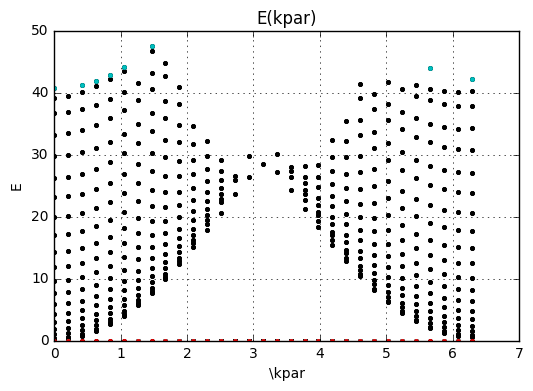

In [32]:
## Plotting eigenvalues

kpar = 2.0*np.pi*SHIFT + 2.0*np.pi/3.0

plt.plot(kpar,E,'k.')
#plt.plot(kpar,E[:,int(2*Ly+2)],'g.')
plt.plot(kpar,E[:,int(2*Ly-1)],'c.')
plt.plot(kpar,E[:,int(2*Ly-0)],'r.')
#plt.plot(kpar,E[:,int(2*Ly+1)],'b.')
#plt.plot(kpar,E[:,int(2*Ly+2)],'y.')

plt.xlabel('\kpar')
plt.ylabel('E')
plt.title('E(kpar)')
#plt.title('Time Reversal Symmetry Broken')
#plt.title('Spatial Reversal Symmetry Broken')
plt.grid(True)

plt.show()

In [33]:
print E[:,int(2*Ly-1)]
print E[:,int(2*Ly-0)]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.])

In [34]:
## Plotting eigenfunctions
    
#eigensolver = SLEPcEigenSolver(A,M)
#eigensolver.parameters['spectrum'] = 'smallest real'
#eigensolver.parameters['solver']   = 'krylov-schur'
#eigensolver.parameters['tolerance'] = 1.e-10   # 1.e-12
#eigensolver.solve(evals)

In [35]:
#r, c, rx, cx = eigensolver.get_eigenpair(int(round(2*Ly-4)))
#u = Function(W)
#u.vector()[:] = rx
#u_r, u_i = split(u)
#plot(u_r)
#interactive()

In [36]:
#import scipy.io
#scipy.io.savemat('matlab export/E_kpar_time.mat', dict(E=E, kpar=kpar))
##scipy.io.savemat('matlab export/E_kpar_spatial.mat', dict(E=E, kpar=kpar))